In [1]:
import os, glob
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:

import os, subprocess

url_base = "https://groups.uni-paderborn.de/kat/BearingDataCenter"
files = ["K001.rar", "KA01.rar", "KI01.rar", "KA22.rar", "KI14.rar", "KB23.rar"]

os.makedirs("/content/PU_rars", exist_ok=True)

for f in files:
    url = f"{url_base}/{f}"
    out = f"/content/PU_rars/{f}"
    print(f"↓ Descargando {f} ...")
    subprocess.run(["wget", "-c", "--show-progress", "-O", out, url], check=True)

↓ Descargando K001.rar ...
↓ Descargando KA01.rar ...
↓ Descargando KI01.rar ...
↓ Descargando KA22.rar ...
↓ Descargando KI14.rar ...
↓ Descargando KB23.rar ...


In [3]:
import glob
out_dir = "/content/PU_extracted_root"
os.makedirs(out_dir, exist_ok=True)

rar_files = sorted(glob.glob("/content/PU_rars/*.rar"))

for rp in rar_files:
    base = os.path.splitext(os.path.basename(rp))[0]  # ej. K001
    dest = os.path.join(out_dir, base)
    os.makedirs(dest, exist_ok=True)
    print(f"↪️ Extrayendo {os.path.basename(rp)} -> {dest}")
    res = subprocess.run(["unrar", "x", "-o+", "-y", "-inul", rp, dest])
    if res.returncode != 0:
        print("⚠️ Error al extraer:", rp)

print("✅ Extracción terminada.")

↪️ Extrayendo K001.rar -> /content/PU_extracted_root/K001
↪️ Extrayendo KA01.rar -> /content/PU_extracted_root/KA01
↪️ Extrayendo KA22.rar -> /content/PU_extracted_root/KA22
↪️ Extrayendo KB23.rar -> /content/PU_extracted_root/KB23
↪️ Extrayendo KI01.rar -> /content/PU_extracted_root/KI01
↪️ Extrayendo KI14.rar -> /content/PU_extracted_root/KI14
✅ Extracción terminada.


In [4]:
import os, glob
# Definir mapa de clases
out_dir = "/content/PU_extracted_root"
label_map = {
    "K001": 0,  # Healthy
    "KA01": 1, "KA22": 1, "KB23": 1,  # Outer faults
    "KI01": 2, "KI14": 2               # Inner faults
}

for folder in label_map.keys():
    mat_files = glob.glob(f"{out_dir}/{folder}/**/*.mat", recursive=True)
    print(f"{folder}: {len(mat_files)} archivos")


K001: 80 archivos
KA01: 80 archivos
KA22: 80 archivos
KB23: 80 archivos
KI01: 80 archivos
KI14: 80 archivos


In [5]:

import numpy as np
from scipy.io import loadmat

def flatten_candidates(obj):
    """Explora recursivamente y devuelve arrays numéricos encontrados en un .mat"""
    cands = []
    if isinstance(obj, np.ndarray):
        if obj.dtype == object:
            for x in obj.ravel():
                cands.extend(flatten_candidates(x))
        else:
            cands.append(np.asarray(obj))
    elif hasattr(obj, "__dict__"):  # caso mat_struct
        for v in obj.__dict__.values():
            cands.extend(flatten_candidates(v))
    return cands

def extract_signal(path, min_len=1000):
    """Carga un archivo .mat y devuelve el vector 1D más largo"""
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    cands = []
    for k, v in mat.items():
        if not k.startswith("__"):  # ignorar metadata
            cands.extend(flatten_candidates(v))
    best, best_len = None, -1
    for a in cands:
        arr = np.array(a).squeeze()
        if arr.ndim == 1 and arr.size > best_len:
            best, best_len = arr, arr.size
    return best


In [6]:
X, y = [], []

for folder in label_map.keys():
    mat_files = glob.glob(f"{out_dir}/{folder}/**/*.mat", recursive=True)
    for mf in mat_files:
        sig = extract_signal(mf)
        if sig is not None:
            step = 4096 // 2   # 50% solapamiento
            for start in range(0, len(sig)-4096, step):
                seg = sig[start:start+4096]
                X.append(seg)
                y.append(label_map[folder])

X = np.array(X)
y = np.array(y)

print("Dataset construido:", X.shape, y.shape)


Dataset construido: (59564, 4096) (59564,)


In [7]:
import numpy as np

unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Clase {u}: {c} segmentos")


Clase 0: 9921 segmentos
Clase 1: 29790 segmentos
Clase 2: 19853 segmentos


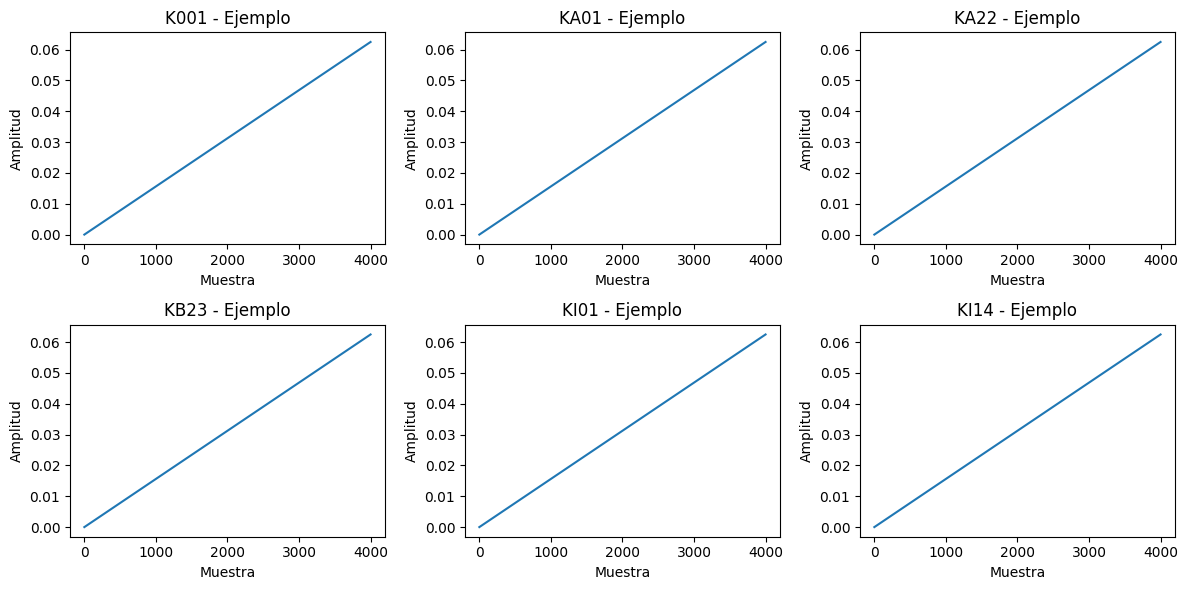

In [8]:
plt.figure(figsize=(12,6))

for i, folder in enumerate(label_map.keys()):
    mat_files = glob.glob(f"{out_dir}/{folder}/**/*.mat", recursive=True)
    if len(mat_files) > 0:
        sig = extract_signal(mat_files[0])
        plt.subplot(2,3,i+1)
        plt.plot(sig[:4000])  # mostrar primeros samples
        plt.title(f"{folder} - Ejemplo")
        plt.xlabel("Muestra")
        plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()


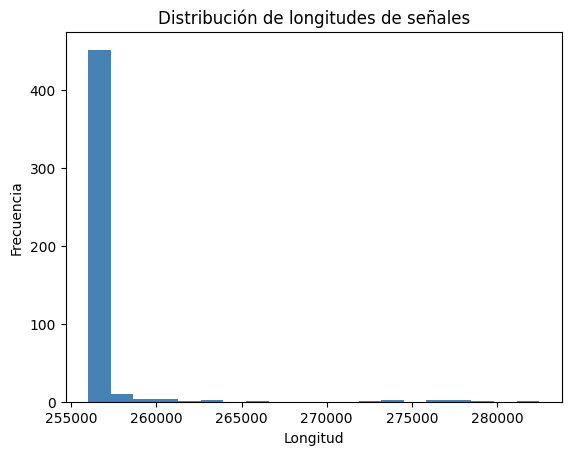

In [9]:
lengths = []
for folder in label_map.keys():
    mat_files = glob.glob(f"{out_dir}/{folder}/**/*.mat", recursive=True)
    for mf in mat_files:
        sig = extract_signal(mf)
        if sig is not None:
            lengths.append(len(sig))

plt.hist(lengths, bins=20, color='steelblue')
plt.title("Distribución de longitudes de señales")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.show()


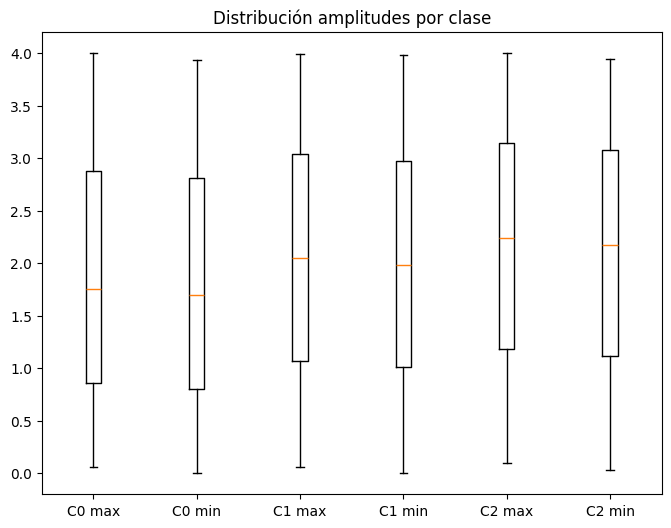

In [10]:
import random

plt.figure(figsize=(8,6))
for cls in np.unique(y):
    idx = np.where(y == cls)[0]
    # muestreamos 200 segmentos para no saturar
    sample_idx = random.sample(list(idx), min(200, len(idx)))
    max_vals = [np.max(X[i]) for i in sample_idx]
    min_vals = [np.min(X[i]) for i in sample_idx]
    plt.boxplot([max_vals, min_vals], positions=[cls*2, cls*2+1])

plt.xticks([0,1,2,3,4,5], ["C0 max","C0 min","C1 max","C1 min","C2 max","C2 min"])
plt.title("Distribución amplitudes por clase")
plt.show()


In [11]:
import pandas as pd

stats = []
for cls in np.unique(y):
    idx = np.where(y == cls)[0]
    sample = X[idx[:1000]]  # tomamos 1000 segmentos para estadísticas
    stats.append({
        "Clase": cls,
        "N": len(idx),
        "Media": np.mean(sample),
        "Desv": np.std(sample),
        "Min": np.min(sample),
        "Max": np.max(sample)
    })

df_stats = pd.DataFrame(stats)
print(df_stats)


   Clase      N     Media      Desv       Min       Max
0      0   9921  1.986572  1.150493 -0.000010  3.999984
1      1  29790  1.977615  1.151787  0.000000  3.999984
2      2  19853  1.984113  1.151828 -0.000006  3.999984


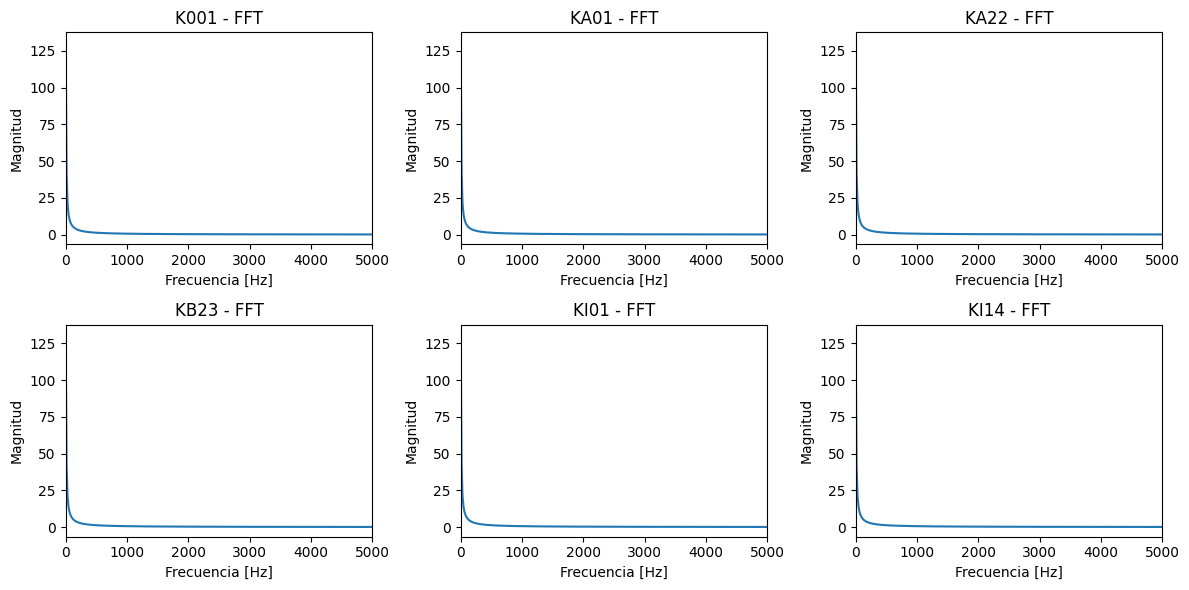

In [12]:
from scipy.fft import rfft, rfftfreq

fs = 64000  # frecuencia de muestreo en Hz
plt.figure(figsize=(12,6))

for i, folder in enumerate(label_map.keys()):
    mat_files = glob.glob(f"{out_dir}/{folder}/**/*.mat", recursive=True)
    if len(mat_files) > 0:
        sig = extract_signal(mat_files[0])
        sig = sig[:4096]
        N = len(sig)
        fft_vals = np.abs(rfft(sig))
        freqs = rfftfreq(N, d=1/fs)

        plt.subplot(2,3,i+1)
        plt.plot(freqs, fft_vals)
        plt.title(f"{folder} - FFT")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud")
        plt.xlim(0, 5000)   # mirar solo hasta 5 kHz (lo interesante suele estar ahí)

plt.tight_layout()
plt.show()


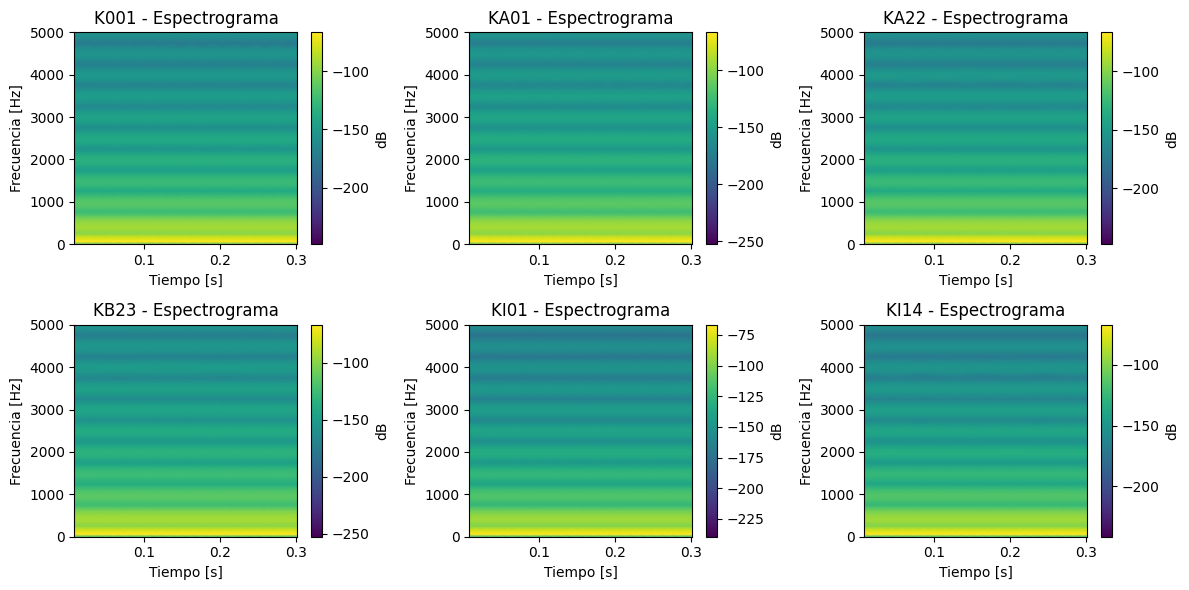

In [13]:
from scipy import signal

fs = 64000  # Hz
plt.figure(figsize=(12,6))

for i, folder in enumerate(label_map.keys()):
    mat_files = glob.glob(f"{out_dir}/{folder}/**/*.mat", recursive=True)
    if len(mat_files) > 0:
        sig = extract_signal(mat_files[0])
        f, t, Sxx = signal.spectrogram(sig[:20000], fs=fs, nperseg=1024)

        plt.subplot(2,3,i+1)
        plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
        plt.title(f"{folder} - Espectrograma")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Frecuencia [Hz]")
        plt.ylim(0, 5000)  # solo hasta 5 kHz
        plt.colorbar(label="dB")

plt.tight_layout()
plt.show()


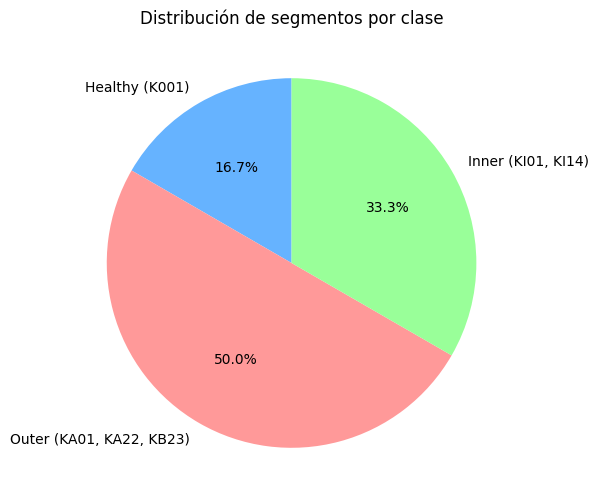

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Conteo por clase (antes o después del balanceo, depende de qué dataset uses)
unique, counts = np.unique(y, return_counts=True)  # usa y_bal si quieres el balanceado

# Etiquetas legibles
labels = {0: "Healthy (K001)", 1: "Outer (KA01, KA22, KB23)", 2: "Inner (KI01, KI14)"}
label_names = [labels[u] for u in unique]

# Gráfico de torta
plt.figure(figsize=(6,6))
plt.pie(counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999','#99ff99'])
plt.title("Distribución de segmentos por clase")
plt.show()


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos automáticamente
classes = np.unique(y)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weights_dict = dict(zip(classes, class_weights))

print("Pesos de clase:", class_weights_dict)


Pesos de clase: {np.int64(0): np.float64(2.001276753015489), np.int64(1): np.float64(0.6664876356719257), np.int64(2): np.float64(1.0000839503685421)}


In [16]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs=64000, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass(sig, lowcut=1000, highcut=20000, fs=64000):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, sig)

# Aplicar a todos los segmentos
X_filt = np.array([apply_bandpass(x, 500, 10000, fs=64000) for x in X])


In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_flat = X_filt.reshape(len(X_filt), -1)
X_scaled = scaler.fit_transform(X_flat)
X_norm = X_scaled.reshape(X_filt.shape)
X_norm = np.expand_dims(X_norm, axis=-1)


In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paso 1: one-hot encoding de y
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# Paso 2: split en train/test a partir de X_norm
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y   # mantiene proporción de clases
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (47651, 4096, 1) (47651, 3)
Test : (11913, 4096, 1) (11913, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

model1D = Sequential()

# Capa 1
model1D.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu', input_shape=(X_train.shape[1],1)))
model1D.add(MaxPooling1D(pool_size=2))
model1D.add(Dropout(0.2))

# Capa 2
model1D.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model1D.add(MaxPooling1D(pool_size=2))
model1D.add(Dropout(0.2))

# Capa 3
model1D.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model1D.add(MaxPooling1D(pool_size=2))
model1D.add(Dropout(0.2))

# Clasificación
model1D.add(Flatten())
model1D.add(Dense(128, activation='relu'))
model1D.add(Dropout(0.3))
model1D.add(Dense(num_classes, activation='softmax'))

model1D.summary()

# Compilar
model1D.compile(loss='categorical_crossentropy',
                optimizer='nadam',
                metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2048, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1024, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 512, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,285,699 (16.35 MB)

 Trainable params: 4,285,699 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model1D.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    class_weight=class_weights_dict,   # ⚡ ya lo calculaste antes
    verbose=1
)


Epoch 1/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.3207 - loss: 1.1017 - val_accuracy: 0.1673 - val_loss: 1.1018
Epoch 2/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 68s 63ms/step - accuracy: 0.3426 - loss: 1.0991 - val_accuracy: 0.1673 - val_loss: 1.0987
Epoch 3/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.3554 - loss: 1.0973 - val_accuracy: 0.5002 - val_loss: 1.0973
Epoch 4/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.3719 - loss: 1.0984 - val_accuracy: 0.3343 - val_loss: 1.0982
Epoch 5/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.3570 - loss: 1.0965 - val_accuracy: 0.3345 - val_loss: 1.0978
Epoch 6/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.3576 - loss: 1.0957 - val_accuracy: 0.1698 - val_loss: 1.1015
Epoch 7/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.2588 - loss: 1.0959 - val_accuracy: 0.5013 - val_loss: 1.0973
Epoch 8/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.3892 - loss: 1

In [22]:
from tensorflow.keras.utils import Sequence
class SpecGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, fs=64000, nperseg=512, noverlap=256, fmax=20000, size=128, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fs = fs
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.fmax = fmax
        self.size = size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_X, batch_y = [], []
        for i in batch_idx:
            f, t, Sxx = signal.spectrogram(self.X[i].squeeze(), fs=self.fs, nperseg=self.nperseg, noverlap=self.noverlap)
            mask = f <= self.fmax
            Sxx = Sxx[mask, :]
            Sxx = 10 * np.log10(Sxx + 1e-10)
            Sxx = cv2.resize(Sxx, (self.size, self.size))
            batch_X.append(Sxx)
            batch_y.append(self.y[i])
        batch_X = np.array(batch_X)[..., np.newaxis]  # (batch, 128, 128, 1)
        batch_y = np.array(batch_y)
        return batch_X, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [23]:
train_gen = SpecGenerator(X_train, y_train, batch_size=64, size=128, shuffle=True)
valid_gen = SpecGenerator(X_test, y_test, batch_size=64, size=128, shuffle=False)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense

model2D = Sequential()

model2D.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,1)))
model2D.add(MaxPooling2D((2,2)))
model2D.add(Dropout(0.2))

model2D.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model2D.add(MaxPooling2D((2,2)))
model2D.add(Dropout(0.3))

model2D.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model2D.add(MaxPooling2D((2,2)))
model2D.add(Dropout(0.3))

model2D.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model2D.add(MaxPooling2D((2,2)))
model2D.add(Dropout(0.4))

model2D.add(GlobalAveragePooling2D())
model2D.add(Dense(128, activation='relu'))
model2D.add(Dropout(0.5))
model2D.add(Dense(num_classes, activation='softmax'))

model2D.summary()
model2D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,123 (1.61 MB)

 Trainable params: 421,123 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model2D.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=40,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 66s 72ms/step - accuracy: 0.4867 - loss: 2.2625 - val_accuracy: 0.5001 - val_loss: 1.0398 - learning_rate: 0.0010
Epoch 2/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.5009 - loss: 1.0161 - val_accuracy: 0.5001 - val_loss: 1.0210 - learning_rate: 0.0010
Epoch 3/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.4999 - loss: 1.0149 - val_accuracy: 0.5001 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 4/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.5019 - loss: 1.0108 - val_accuracy: 0.5001 - val_loss: 1.0134 - learning_rate: 0.0010
Epoch 5/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - accuracy: 0.5011 - loss: 1.0123 - val_accuracy: 0.5001 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 6/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.5002 - loss: 1.0125 - val_accuracy: 0.5001 - val_loss: 1.0113 - learning_rate: 0.0010
Epoch 7/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.4994 - l